In [75]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import gymnasium as gym
import numpy as np
from scipy.stats import poisson


class JacksCarRentalEnv(gym.Env):
    """
    Jack's Car Rental environment
    """

    def __init__(self, max_cars=20, max_move_cars=5, rental_credit=10, move_car_cost=2,
                 request_lambda=[3, 4], return_lambda=[3, 2], init_state_option="random",
                 poisson_max_value=12):
        """
        Initialize the environment.
        """
        self.max_cars = max_cars
        self.max_move_cars = max_move_cars
        self.rental_credit = rental_credit
        self.move_car_cost = move_car_cost
        self.request_lambda = request_lambda
        self.return_lambda = return_lambda

        self.action_space = gym.spaces.Discrete(2 * max_move_cars + 1)
        self.observation_space = gym.spaces.Tuple(
            (gym.spaces.Discrete(max_cars + 1), gym.spaces.Discrete(max_cars + 1))
        )

        self._precompute_poisson_probabilities(max_value=poisson_max_value)
        self.reset(init_state_option)

    def _move_cars_and_calculate_cost(self, state, action):
        cars_at_A, cars_at_B = state
        cars_moved = min(cars_at_A if action > 0 else cars_at_B, abs(action), self.max_move_cars)
        cars_at_A -= cars_moved * np.sign(action)
        cars_at_B += cars_moved * np.sign(action)
        return (max(cars_at_A, 0), max(cars_at_B, 0)), abs(action) * self.move_car_cost

    def _simulate_rentals_and_returns(self, state):
        cars_at_A, cars_at_B = state
        requests_A = poisson.rvs(self.request_lambda[0])
        requests_B = poisson.rvs(self.request_lambda[1])
        returns_A = poisson.rvs(self.return_lambda[0])
        returns_B = poisson.rvs(self.return_lambda[1])
        
        rentals_A = min(cars_at_A, requests_A)
        rentals_B = min(cars_at_B, requests_B)
        
        reward = (rentals_A + rentals_B) * self.rental_credit
        
        cars_at_A = min(cars_at_A - rentals_A + returns_A, self.max_cars)
        cars_at_B = min(cars_at_B - rentals_B + returns_B, self.max_cars)
        
        return (cars_at_A, cars_at_B), reward

    def step(self, action):
        """
        Execute one time step within the environment.
        """
        action = action - self.max_move_cars
        moved_state, move_cost = self._move_cars_and_calculate_cost(self.state, action)
        new_state, rental_reward = self._simulate_rentals_and_returns(moved_state)
        reward = rental_reward - move_cost
        self.state = new_state
        return new_state, reward, False, {}

    def reset(self, option="random"):
        """
        Reset the state of the environment to an initial state.
        """
        if option == "random":
            self.state = (np.random.randint(0, self.max_cars + 1),
                          np.random.randint(0, self.max_cars + 1))
        elif option == "equal":
            initial_cars = self.max_cars // 2
            self.state = (initial_cars, initial_cars)
        return self.state

    def render(self, mode='human'):
        """
        Render the environment.
        """
        if mode == 'human':
            print(f"Location A: {self.state[0]} cars, Location B: {self.state[1]} cars")
        elif mode == 'ansi':
            return f"Location A: {self.state[0]} cars, Location B: {self.state[1]} cars"
        else:
            raise NotImplementedError("Render mode not supported: " + mode)

    def _precompute_poisson_probabilities(self, max_value=12):
        """Precomputes and stores Poisson probabilities for rental requests and returns."""
        self.poisson_probs = {
            "request": {
                "A": [poisson.pmf(i, self.request_lambda[0]) for i in range(max_value + 1)],
                "B": [poisson.pmf(i, self.request_lambda[1]) for i in range(max_value + 1)]
            },
            "return": {
                "A": [poisson.pmf(i, self.return_lambda[0]) for i in range(max_value + 1)],
                "B": [poisson.pmf(i, self.return_lambda[1]) for i in range(max_value + 1)]
            }
        }
        
    def _get_probability_of_rental_requests(self, request_A, request_B):
        """Returns the probability of the given number of rental requests."""
        return self.poisson_probs["request"]["A"][request_A] * self.poisson_probs["request"]["B"][request_B]

    def _get_probability_of_car_returns(self, return_A, return_B):
        """Returns the probability of the given number of car returns."""
        return self.poisson_probs["return"]["A"][return_A] * self.poisson_probs["return"]["B"][return_B]
        
    def build_mdp(self):
        t_r_dict = {}

        for cars_at_A in range(self.max_cars + 1):
            for cars_at_B in range(self.max_cars + 1):
                state = (cars_at_A, cars_at_B)

                for action in range(-self.max_move_cars, self.max_move_cars + 1):
                    moved_state, move_cost = self._move_cars_and_calculate_cost(state, action)

                    for request_A in range(0, self.max_cars + 1):
                        for request_B in range(0, self.max_cars + 1):
                            prob_request = self.poisson_probs["request"]["A"][request_A] * \
                                           self.poisson_probs["request"]["B"][request_B]
                            rentals_A = min(moved_state[0], request_A)
                            rentals_B = min(moved_state[1], request_B)
                            rental_reward = (rentals_A + rentals_B) * self.rental_credit

                            for return_A in range(0, self.max_cars + 1):
                                for return_B in range(0, self.max_cars + 1):
                                    prob_return = self.poisson_probs["return"]["A"][return_A] * \
                                                  self.poisson_probs["return"]["B"][return_B]
                                    next_state = (min(moved_state[0] - rentals_A + return_A, self.max_cars),
                                                  min(moved_state[1] - rentals_B + return_B, self.max_cars))
                                    prob_total = prob_request * prob_return
                                    reward = rental_reward - move_cost

                                    if (state, action) in t_r_dict:
                                        existing_state, existing_reward, existing_done = t_r_dict[(state, action)]
                                        t_r_dict[(state, action)] = (existing_state, existing_reward + prob_total * reward, existing_done)
                                    else:
                                        t_r_dict[(state, action)] = (next_state, prob_total * reward, False)

        return t_r_dict


# Example usage
env = JacksCarRentalEnv(
    max_cars=10,
    max_move_cars=3,
    request_lambda=[2, 2],
    return_lambda=[2, 2],
    init_state_option="equal",
)
env.state

(5, 5)

In [90]:
t_r_dict = env.build_mdp()
t_r_dict

{((0, 0), -3): ((0, 0), -5.9998006050996375, False),
 ((0, 0), -2): ((0, 0), -3.99986707006686, False),
 ((0, 0), -1): ((0, 0), -1.99993353503343, False),
 ((0, 0), 0): ((0, 0), 0.0, False),
 ((0, 0), 1): ((0, 0), -1.99993353503343, False),
 ((0, 0), 2): ((0, 0), -3.99986707006686, False),
 ((0, 0), 3): ((0, 0), -5.9998006050996375, False),
 ((0, 1), -3): ((1, 0), 2.6465479692973872, False),
 ((0, 1), -2): ((1, 0), 4.646481504330314, False),
 ((0, 1), -1): ((1, 0), 6.64641503936425, False),
 ((0, 1), 0): ((0, 1), 8.646348574396937, False),
 ((0, 1), 1): ((0, 1), 6.646415039364336, False),
 ((0, 1), 2): ((0, 1), 4.646481504330393, False),
 ((0, 1), 3): ((0, 1), 2.646547969297433, False),
 ((0, 2), -3): ((2, 0), 8.58625834215566, False),
 ((0, 2), -2): ((2, 0), 10.58619187718956, False),
 ((0, 2), -1): ((1, 1), 15.29276361376049, False),
 ((0, 2), 0): ((0, 2), 14.586058947255527, False),
 ((0, 2), 1): ((0, 2), 12.586125412221705, False),
 ((0, 2), 2): ((0, 2), 10.5861918771896, False),
 

Optimal Policy: {(4, 0): 2, (4, 9): -1, (5, 1): 2, (8, 0): 3, (5, 10): 0, (8, 9): 0, (10, 6): 0, (9, 8): 0, (0, 5): -2, (2, 2): 0, (6, 2): 2, (7, 1): 3, (7, 10): 0, (4, 2): 1, (3, 6): -1, (5, 3): 1, (8, 2): 3, (9, 1): 3, (9, 10): 0, (0, 7): -3, (2, 4): -1, (1, 8): -3, (6, 4): 1, (7, 3): 2, (3, 8): -2, (5, 5): 0, (8, 4): 1, (9, 3): 2, (0, 0): 0, (0, 9): -3, (1, 10): -3, (6, 6): 0, (7, 5): 0, (3, 1): 1, (3, 10): -2, (5, 7): 0, (9, 5): 0, (0, 2): -1, (1, 3): -1, (7, 7): 0, (3, 3): 0, (5, 0): 2, (5, 9): 0, (9, 7): 0, (10, 8): 0, (1, 5): -2, (6, 1): 2, (7, 0): 3, (7, 9): 0, (3, 5): -1, (5, 2): 1, (4, 4): 0, (9, 0): 3, (9, 9): 0, (10, 1): 3, (10, 10): 0, (1, 7): -3, (2, 6): -2, (7, 2): 2, (3, 7): -2, (5, 4): 0, (4, 6): -1, (9, 2): 3, (8, 6): 0, (10, 3): 2, (1, 0): 0, (1, 9): -3, (2, 8): -3, (7, 4): 1, (6, 8): 0, (3, 0): 1, (3, 9): -2, (5, 6): 0, (4, 8): -1, (8, 8): 0, (10, 5): 0, (1, 2): 0, (0, 4): -2, (2, 1): 0, (2, 10): -3, (6, 10): 0, (3, 2): 0, (4, 1): 1, (4, 10): -1, (8, 1): 3, (8, 10):

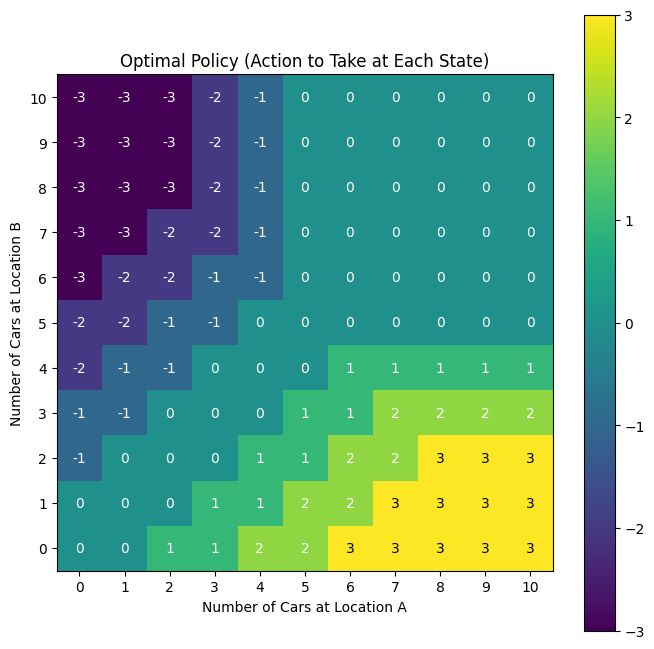

In [93]:
from visualize import plot_car_rental_policy, plot_car_rental_value_function
from value_iteration import value_iteration_v, value_iteration_q
from policy_iteration import policy_evaluation_v, find_optimal_policy_q

# Parameters for policy iteration
gamma = 0.9
theta = 1e-6

# Find the optimal policy using Q-value iteration
optimal_policy, optimal_value_function_q = find_optimal_policy_q(t_r_dict)

print("Optimal Policy:", optimal_policy)
print("Value Function:", optimal_value_function_q)

# Extract V from Q
states = list(set([s for s, _ in t_r_dict.keys()]))
V = {state: 0 for state in states}
optimal_V = policy_evaluation_v(states, optimal_policy, V, t_r_dict, gamma, theta)
print("Optimal Value Function:", optimal_V)

# Draw the GridWorld with the optimal policy and value function
plot_car_rental_policy(optimal_policy, max_cars=env.max_cars)

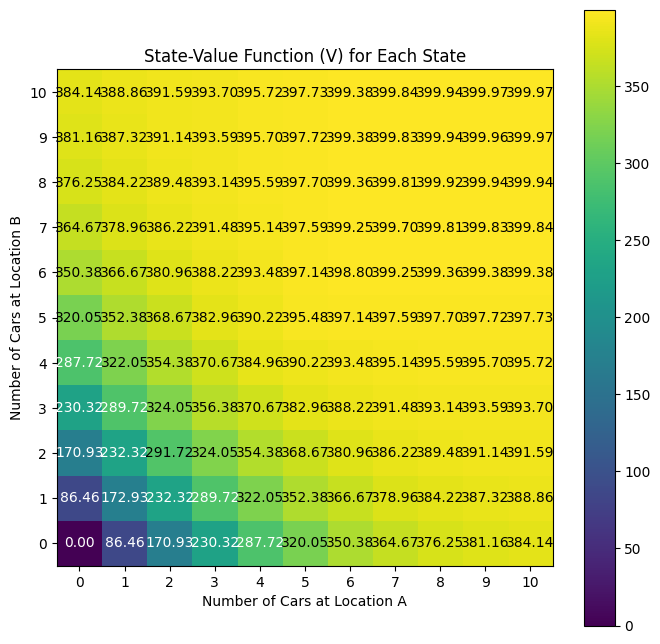

In [94]:
plot_car_rental_value_function(optimal_V, max_cars=env.max_cars)

In [80]:
[(key, t_r_dict[key]) for key in t_r_dict.keys() if (6, 6) in key]

[(((6, 6), -3), ((6, 3), 30.954864221175637, False)),
 (((6, 6), -2), ((6, 4), 34.283535646914274, False)),
 (((6, 6), -1), ((6, 5), 36.722187974861946, False)),
 (((6, 6), 0), ((6, 6), 38.8048326636937, False)),
 (((6, 6), 1), ((5, 6), 36.722187974861995, False)),
 (((6, 6), 2), ((4, 6), 34.283535646914274, False)),
 (((6, 6), 3), ((3, 6), 30.95486422117569, False))]

In [81]:
optimal_value_function_q[(6, 5)]

{0: 386.86163333133436,
 1: 384.8976590307562,
 2: 379.6233995625304,
 3: 372.0226427621098,
 -1: 381.58737433891014,
 -3: 362.83823901896466,
 -2: 373.98661823790087}